In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil.relativedelta import relativedelta

import os
import cx_Oracle
from sqlalchemy import create_engine
import sqlite3
import warnings
import json
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 100)

C:\Users\tunahan.aktas\Anaconda3\lib\site-packages\mpl_toolkits\mplot3d\__init__.py:1: MatplotlibDeprecationWarning: 
The deprecated function was deprecated in Matplotlib 3.4 and will be removed two minor releases later.
  from .axes3d import Axes3D


---
# HİSTORİK DATANIN ÇEKİLMESİ
---

In [2]:
f = open("../config.json", "r")
params_ = json.loads(f.read())

In [3]:
params_["time_info_for_debugging"]["yil"] = 2021
params_["time_info_for_debugging"]["ay"] = 12

In [4]:
time_filter = datetime(params_["time_info_for_debugging"]["yil"], params_["time_info_for_debugging"]["ay"], 1)
sql_query = f"SELECT * FROM DS_HISTORY_DATA WHERE datanin_kesildigi_tarih = '{time_filter}'"

In [5]:
conn = sqlite3.connect("../data/db/DS_DATABASE.sqlite")

In [6]:
df_all = pd.read_sql_query(sql_query, con=conn)
df_all["date"] = pd.to_datetime(df_all["date"])

df_preds = pd.read_sql("SELECT * FROM DS_OUTPUT_TEST", con=conn)
df_preds["TARIH"] = pd.to_datetime(df_preds["TARIH"])

In [7]:
conn.close()

In [8]:
df_all["indirim__bins"] = df_all["indirim__"].apply(lambda x: 0 if x <= 0 else 
                                                    (1 if x <= 0.01 else 
                                                     (2 if x <= 0.02 else 
                                                      (3 if x <= 0.03 else 
                                                       (4 if x <= 0.04 else 
                                                        (5 if x <= 0.05 else 
                                                         (6 if x <= 0.06 else 
                                                          (7 if x <= 0.07 else 
                                                           (8 if x <= 0.08 else 
                                                            (9 if x <= 0.09 else 
                                                             (10 if x <= 0.10 else 
                                                              (12.5 if x <= 0.15 else 15))))))))))))

df_all.indirim__bins = df_all.indirim__bins.apply(lambda x: '0' if x == 0 or x == '0.0' else 
                                                    ('%0 - %1' if x == 1 else 
                                                     ('%1 - %2' if x == 2 else 
                                                      ('%2 - %3' if x == 3 else 
                                                       ('%3 - %4' if x == 4 else 
                                                        ('%4 - %5' if x == 5 else 
                                                         ('%5 - %6' if x == 6 else 
                                                          ('%6 - %7' if x == 7 else 
                                                           ('%7 - %8' if x == 8 else 
                                                            ('%8 - %9' if x == 9 else 
                                                             ('%9 - %10' if x == 10 else 
                                                              ('%10 - %15' if x == 12.5 else 
                                                               ('%15 - max' if x == 15.0 else x)))))))))))))

In [9]:
df_all["date"] = pd.to_datetime(df_all["yil"].astype("int64").astype(str) + "-" + df_all["ay"].astype("int64").astype(str) + "-01", format="%Y-%m-%d")

In [10]:
df_all_v8 = df_all.copy()

In [11]:
results = df_preds.copy()
results.columns = [i.lower() for i in results.columns]

In [12]:
results = results[~((results["grup_adi"].str.contains("TÜM")) | 
                    (results["ana_kategori_adi"].str.contains("TÜM")) | 
                    (results["kategori_adi"].str.contains("TÜM")) | 
                    (results["marka_adi"].str.contains("TÜM")) | 
                    (results["urun_adi"].str.contains("TÜM")) | 
                    (results["en_guncel_kod"].str.contains("TÜM")))].reset_index(drop=True)

In [13]:
results = results[["tarih", "kanal", "grup_adi", "en_guncel_kod", "urun_adi", "tahmin_koli", "aktivite_tipi", "indirim_yuzdesi", "tahmin_edilme_yontemi"]]
results.tarih = pd.to_datetime(results.tarih)
results.en_guncel_kod = results.en_guncel_kod.astype("int64")

In [14]:
results.rename(columns={"tarih": "date"}, inplace=True)

# AKTİVİTE DATALARININ ÇEKİLMESİ
---

In [15]:
chng_col_name = {
    
    'Yıl': 'yil',
    'Çeyrek': 'ceyrek',
    'Ay': 'ay',
    'Saha Müşteri Grup': 'grup_adi',
    'grup_adi': 'grup_adi',
    'Müşteri Grup': 'grup_adi',
    'Ana Kategori Adı': 'ana_kategori_adi',
    'Kategori Adı': 'kategori_adi',
    'Marka Adı': 'marka_adi',
    'Ürün Kodu': 'en_guncel_kod',
    'Ürün Adı': 'urun_adi',
    'Ürün Adı (Mobis)': 'urun_adi',
    'urun_adi': 'urun_adi',
    'Raf Tavsiye Satış Fiyatı': 'delete_col1',
    'İndirimli Raf Satış Fiyatı': 'delete_col2',
    'İndirim %': 'indirim__',
    'Aktivite Tipi': 'aktivite_tipi',
    'İskonto %': 'indirim__',
    'Ciro (Kull. İade Düş.)': 'delete_col1',
    'Promosyon Tutarı': 'delete_col2'

}

grup_kanal_dict = {
    
    'A101': 'pasifik', 
    'BİM': 'pasifik', 
    'Diğer_Pasifik': 'pasifik', 
    'MİGROS': 'pasifik', 
    'ŞOK': 'pasifik', 
    'Diğer_Horizon': 'horizon', 
    'GELENEKSEL KANAL': 'horizon', 
    'ORTA MARKET': 'horizon', 
    'POTANSİYEL MARKET': 'horizon', 
    'YEREL ZİNCİR': 'horizon', 
    'BTT': 'btt'
                    
                }

regulate_akt = {
    
    'CRM': 'CRM', 
    'Kasiyer': 'Kasiyer', 
    'Mağaza içi/Dağılım': 'Mağaza içi/Dağılım', 
    'Mutluluk': 'Mutluluk', 
    'Çoklu Alım': 'Çoklu Alım', 
    'İn&out': 'In-out'

}

# Pasifik
---

In [16]:
akt_col_orders = ["date", "kanal", "grup_adi", "ana_kategori_adi", "kategori_adi", "marka_adi", "en_guncel_kod", "urun_adi", "indirim_yuzdesi_new", "aktivite_tipi_new"]

In [17]:
pas_akt = pd.read_excel("../data/"+[i for i in os.listdir("../data/") if i.startswith("Pasifik Aktivite Datası ")][0])
#hor_akt = pd.read_excel("../data/graph_data/horizon_aktivite.xlsx")

In [18]:
pas_akt.rename(columns=chng_col_name, inplace=True)
pas_akt["date"] = pd.to_datetime(pas_akt["yil"].astype(str) + "-" + pas_akt["ay"].astype(str) + "-01", format="%Y-%m-%d")
pas_akt["kanal"] = pas_akt["grup_adi"].map(grup_kanal_dict)

In [19]:
pas_akt["indirim__"] = pas_akt["indirim__"].apply(lambda x: 0 if x <= 0 else 
                                                  (1 if x <= 0.01 else 
                                                   (2 if x <= 0.02 else 
                                                    (3 if x <= 0.03 else 
                                                     (4 if x <= 0.04 else 
                                                      (5 if x <= 0.05 else 
                                                       (6 if x <= 0.06 else 
                                                        (7 if x <= 0.07 else 
                                                         (8 if x <= 0.08 else 
                                                          (9 if x <= 0.09 else 
                                                           (10 if x <= 0.10 else 
                                                            (12.5 if x <= 0.15 else 15))))))))))))

pas_akt["indirim_yuzdesi_new"] = pas_akt["indirim__"].apply(lambda x: '0' if x == 0 or x == '0.0' else 
                                                      ('%0 - %1' if x == 1 else 
                                                       ('%1 - %2' if x == 2 else 
                                                        ('%2 - %3' if x == 3 else 
                                                         ('%3 - %4' if x == 4 else 
                                                          ('%4 - %5' if x == 5 else 
                                                           ('%5 - %6' if x == 6 else 
                                                            ('%6 - %7' if x == 7 else 
                                                             ('%7 - %8' if x == 8 else 
                                                              ('%8 - %9' if x == 9 else 
                                                               ('%9 - %10' if x == 10 else 
                                                                ('%10 - %15' if x == 12.5 else 
                                                                 ('%15 - max' if x == 15.0 else x)))))))))))))

In [20]:
pas_akt["aktivite_tipi_new"] = pas_akt["aktivite_tipi"].map(regulate_akt)

In [21]:
pas_akt.drop(columns=["ceyrek", "yil", "ay", "indirim__", "aktivite_tipi"]+[col for col in pas_akt.columns if col.startswith("delete_col")], axis=1, inplace=True)
pas_akt = pas_akt[akt_col_orders]

In [22]:
pas_akt["grup_adi"] = pas_akt["grup_adi"].apply(lambda x: "Diğer_Pasifik" if x == "Diğer" else x)

---
# Horizon
---

In [23]:
saha_aktivite_lst = sorted([doc_ for doc_ in os.listdir(params_["path"]["horizon_aktivite_path"]) if doc_.startswith("Demand_Sensing_Saha_Aktivit") or doc_.startswith("Demand Sensing Saha Aktivit")])
#saha_aktivite_lst = [doc for doc in saha_aktivite_lst if str(params_["time_info_for_debugging"]["yil"]) in doc or str(params_["time_info_for_debugging"]["yil"]-1) in doc]
saha_aktivite_lst = [doc for doc in saha_aktivite_lst if str(params_["time_info_for_debugging"]["yil"]) in doc or str(params_["time_info_for_debugging"]["yil"]+1) in doc]

In [24]:
hor_akt_all = []
for i in saha_aktivite_lst:
    hor_akt_all.append(pd.read_excel("../data/"+i, skiprows=1, usecols='B:M'))
hor_akt_all = pd.concat(hor_akt_all, ignore_index=True)
hor_akt_all.rename(columns=chng_col_name, inplace=True)
hor_akt_all["grup_adi"] = hor_akt_all["grup_adi"].apply(lambda x: "Diğer_Horizon" if x == "Diğer" else x)

In [25]:
hor_akt = hor_akt_all.copy()

In [26]:
hor_akt["date"] = pd.to_datetime(hor_akt["yil"].astype(str) + "-" + hor_akt["ay"].astype(str) + "-01", format="%Y-%m-%d")
hor_akt["kanal"] = hor_akt["grup_adi"].map(grup_kanal_dict)

In [27]:
hor_akt["indirim__"].replace("#DIV/0", np.nan,inplace=True)

In [28]:
hor_akt["indirim__"] = hor_akt["indirim__"].apply(lambda x: 0 if x <= 0 else 
                                                  (1 if x <= 0.01 else 
                                                   (2 if x <= 0.02 else 
                                                    (3 if x <= 0.03 else 
                                                     (4 if x <= 0.04 else 
                                                      (5 if x <= 0.05 else 
                                                       (6 if x <= 0.06 else 
                                                        (7 if x <= 0.07 else 
                                                         (8 if x <= 0.08 else 
                                                          (9 if x <= 0.09 else 
                                                           (10 if x <= 0.10 else 
                                                            (12.5 if x <= 0.15 else 15))))))))))))

hor_akt["indirim_yuzdesi_new"] = hor_akt["indirim__"].apply(lambda x: '0' if x == 0 or x == '0.0' else 
                                                      ('%0 - %1' if x == 1 else 
                                                       ('%1 - %2' if x == 2 else 
                                                        ('%2 - %3' if x == 3 else 
                                                         ('%3 - %4' if x == 4 else 
                                                          ('%4 - %5' if x == 5 else 
                                                           ('%5 - %6' if x == 6 else 
                                                            ('%6 - %7' if x == 7 else 
                                                             ('%7 - %8' if x == 8 else 
                                                              ('%8 - %9' if x == 9 else 
                                                               ('%9 - %10' if x == 10 else 
                                                                ('%10 - %15' if x == 12.5 else 
                                                                 ('%15 - max' if x == 15.0 else x)))))))))))))

In [29]:
hor_akt["aktivite_tipi_new"] = "Yok"

In [30]:
hor_akt.drop(columns=["ceyrek", "yil", "ay", "indirim__"]+[col for col in hor_akt.columns if col.startswith("delete_col")], axis=1, inplace=True)

---
# Aktivitelerin Birleştirilmesi
---

In [31]:
all_akt = pd.concat([pas_akt, hor_akt], ignore_index=True, axis=0)
all_akt["indirim_yuzdesi_new"] = all_akt["indirim_yuzdesi_new"].apply(lambda x: "0" if x==0 else x)

In [32]:
all_akt = all_akt[["date", "grup_adi", "en_guncel_kod", "indirim_yuzdesi_new", "aktivite_tipi_new"]]

In [33]:
all_akt.drop_duplicates(ignore_index=True, inplace=True)

---
# ARAYÜZDEKİ SONUÇLARDAN AKTİVİTELERE GÖRE FİLTRELEME. ELİMDE SADECE T+1 VE T+2 (KASIM VE ARALIK) AKTİVİTELERİ OLDUĞU VE T+3 VE T+4 TARİHLERİ İÇİN AKTİVİTE TİPLERİ OLMADIĞI İÇİN T+3 VE T+4 İÇİN AKTİVİTE TİPİNİ 0 İNDİRİM YÜZDESİNİ 0 GİRECEĞİM
---

In [34]:
results_backup = results.copy()

In [35]:
results = results.merge(all_akt, how="left")

In [36]:
results_backup.shape, results.shape

((207740, 9), (207740, 11))

In [37]:
results["indirim_yuzdesi_new"].fillna("0", inplace=True)
results["aktivite_tipi_new"].fillna("Yok", inplace=True)

In [38]:
results2 = results[(results["aktivite_tipi"] == results["aktivite_tipi_new"]) & (results["indirim_yuzdesi"] == results["indirim_yuzdesi_new"])].reset_index(drop=True)

In [39]:
data_name_dict = {
    
    1: "Ocak",
    2: "Şubat",
    3: "Mart",
    4: "Nisan",
    5: "Mayıs",
    6: "Haziran",
    7: "Temmuz",
    8: "Ağustos",
    9: "Eylül",
    10: "Ekim",
    11: "Kasım",
    12: "Aralık"
}

In [40]:
#t_2 = datetime(params_["time_info_for_debugging"]["yil"], params_["time_info_for_debugging"]["ay"], 1) + relativedelta(months=2)
t_2 = datetime(2021, 12, 1) + relativedelta(months=2)

In [41]:
yil = t_2.year
ay = data_name_dict[t_2.month]

In [42]:
# results2.to_excel(f"../results/{ay}_{yil}_filtrelenmis_sonuclar.xlsx", index=False)

---
# GERÇEKLEŞEN SONUÇLAR
---

In [43]:
pas_gercek = pd.read_excel("../data/graph_data/pasifik_gerceklesen.xlsx")
hor_gercek = pd.read_excel("../data/graph_data/horizon_gerceklesen.xlsx")

In [44]:
gerceklesen = pd.concat([pas_gercek, hor_gercek], ignore_index=True, axis=0)

In [45]:
gerceklesen.drop_duplicates(ignore_index=True, inplace=True)

In [46]:
results3 = results2.merge(gerceklesen, how="left")
results3.koli.fillna(0, inplace=True)

In [47]:
results3.drop(columns=["indirim_yuzdesi_new", "aktivite_tipi_new"], axis=1, inplace=True)
results3.rename(columns={"kanal": "Kanal"}, inplace=True)
results3.tahmin_koli = results3.tahmin_koli.astype("int64")
results3.koli = results3.koli.replace("--", 0)
results3.koli = results3.koli.astype("int64")

---
# GRAFİKLER
---

In [48]:
df_all_backup = df_all.copy()

In [49]:
df_all["en_guncel_kod"] = df_all["en_guncel_kod"].astype("int64")

In [50]:
df_all.rename(columns={"indirim__bins": "indirim_yuzdesi"}, inplace=True)
df_all.Kanal = df_all.Kanal.map({"horizon": "HORİZON", "pasifik": "PASİFİK", "btt": "BTT"})
df_all2 = pd.concat([df_all, results3], axis=0)
df_all_v8_v2 = pd.concat([df_all_v8, results3], axis=0)

In [51]:
df_all2 = df_all2[df_all2["date"] < results3.date.min() + relativedelta(months=2)].reset_index(drop=True)

In [52]:
df_all2.koli = df_all2.koli.astype("int64")
#df_all2.tahmin_koli.fillna(0, inplace=True)
#df_all2.tahmin_koli = df_all2.tahmin_koli.astype("int64")
#df_all2.tahmin_koli.replace(0, np.nan, inplace=True)

In [53]:
kanal_grup_dict = {
    
    "horizon": ["Diğer_Horizon", "GELENEKSEL KANAL", "ORTA MARKET", "POTANSİYEL MARKET", "YEREL ZİNCİR"],
    "pasifik": ['A101', 'BİM', 'Diğer_Pasifik', 'ŞOK', 'MİGROS']
}

In [54]:
df_all2["en_guncel_kod"] = df_all2["en_guncel_kod"].astype("int64")
df_all_v8_v2["en_guncel_kod"] = df_all_v8_v2["en_guncel_kod"].astype("int64")
results3["en_guncel_kod"] = results3["en_guncel_kod"].astype("int64")

In [55]:
# kontrol 103304

# sku_id = 149904 # Örnek 1 sert düşüş gerçekleşmiş özellikle ŞOK tarafında.
# kanal_adi_id = "pasifik"
# kanal_adi_id2 = "PASİFİK"

# sku_id = 67100 # Örnek 2 bim history'de görülmemiş peak var. Neden?
# kanal_adi_id = "pasifik"
# kanal_adi_id2 = "PASİFİK"

# sku_id = 115906 # Örnek 3 BİM moving average yaparken önceki yılın katsayisi yüksek çıktığı için yüksek tahmin geldi. Çikolata kaplamada farlı bir yöntem mi uygulanıyor?
# kanal_adi_id = "pasifik"
# kanal_adi_id2 = "PASİFİK"

# sku_id = 118807 # Örnek 4 Diğer Pasifik grubunda yüksek satış gerçekleşmiş. Sebebi nedir?
# kanal_adi_id = "pasifik"
# kanal_adi_id2 = "PASİFİK"

# sku_id = 7200 # Örnek 6 BİM'de Ekim ayında çok yüksek alım gerçekleşmiş.
# kanal_adi_id = "pasifik"
# kanal_adi_id2 = "PASİFİK"

# sku_id = 11401 # Örnek 7 MİGROS ve ŞOK çok düşük satış gerçekleşmiş.
# kanal_adi_id = "pasifik"
# kanal_adi_id2 = "PASİFİK"

# sku_id = 18407 # Örnek 8 Kasım ayında bu üründen fazla alımlar mı gerçekleşti bu yüzden mi aralık ayı satışları düşük kalmış?
# kanal_adi_id = "pasifik"
# kanal_adi_id2 = "PASİFİK"

# sku_id = 65309 # Örnek 9 ŞOK'ta ne oldu çok yüksek satış gelmiş?
# kanal_adi_id = "pasifik"
# kanal_adi_id2 = "PASİFİK"

# sku_id = 107802 # Örnek 9 ŞOK'ta ne oldu çok yüksek satış gelmiş?
# kanal_adi_id = "horizon"
# kanal_adi_id2 = "HORİZON"

# sku_id = 9201 # Örnek 9 A101 listeli olmayan hhesabı kontrol et.
# kanal_adi_id = "pasifik"
# kanal_adi_id2 = "PASİFİK"

# sku_id = 117805 # Örnek 9 A101 listeli olmayan hhesabı kontrol et.
# kanal_adi_id = "pasifik"
# kanal_adi_id2 = "PASİFİK"

# sku_id = 8108
# kanal_adi_id = "pasifik"
# kanal_adi_id2 = "PASİFİK"


# sku_id = 176303
# kanal_adi_id = "pasifik"
# kanal_adi_id2 = "PASİFİK"

# sku_id = 67807 # Örnek 1 sert düşüş gerçekleşmiş özellikle ŞOK tarafında.
# kanal_adi_id = "pasifik"
# kanal_adi_id2 = "PASİFİK"

sku_id = 67801 # Örnek 1 sert düşüş gerçekleşmiş özellikle ŞOK tarafında.
kanal_adi_id = "horizon"
kanal_adi_id2 = "HORİZON"

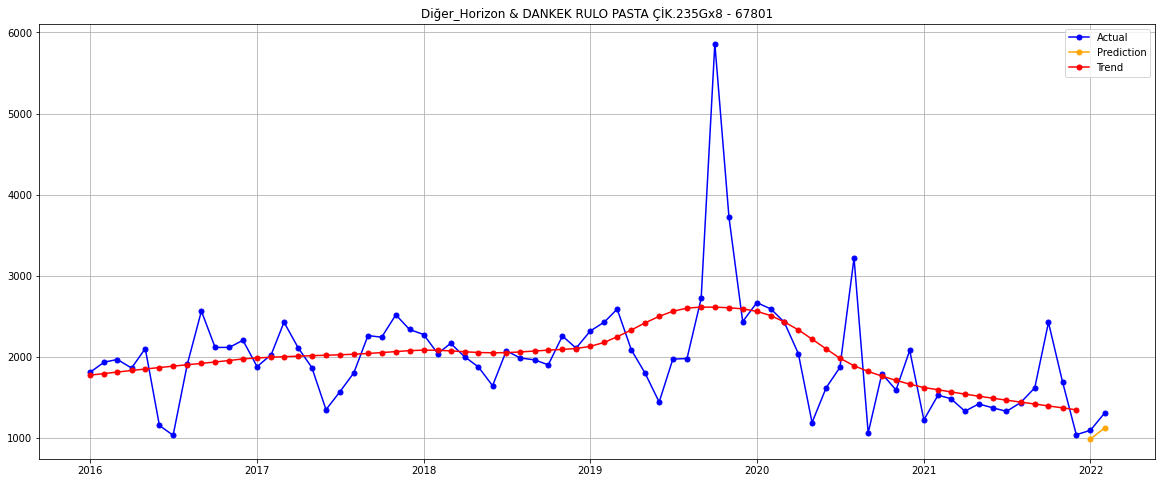



Geçmiş Şubat Ayları
-------------------
            date  koli  tahmin_koli aktivite_tipi indirim_yuzdesi
61138 2016-02-01  1937          NaN           Yok         %2 - %3
61150 2017-02-01  2030          NaN           Yok               0
61162 2018-02-01  2041          NaN           Yok               0
61174 2019-02-01  2431          NaN           Yok         %2 - %3
61186 2020-02-01  2591          NaN           Yok         %3 - %4
61198 2021-02-01  1529          NaN           Yok         %5 - %6


Tahminlenen Aylar - Yöntem: hierarchical_forecast
-----------------
            date  koli  tahmin_koli aktivite_tipi indirim_yuzdesi
66632 2022-01-01  1097        989.0           Yok         %2 - %3
66633 2022-02-01  1309       1126.0           Yok         %2 - %3




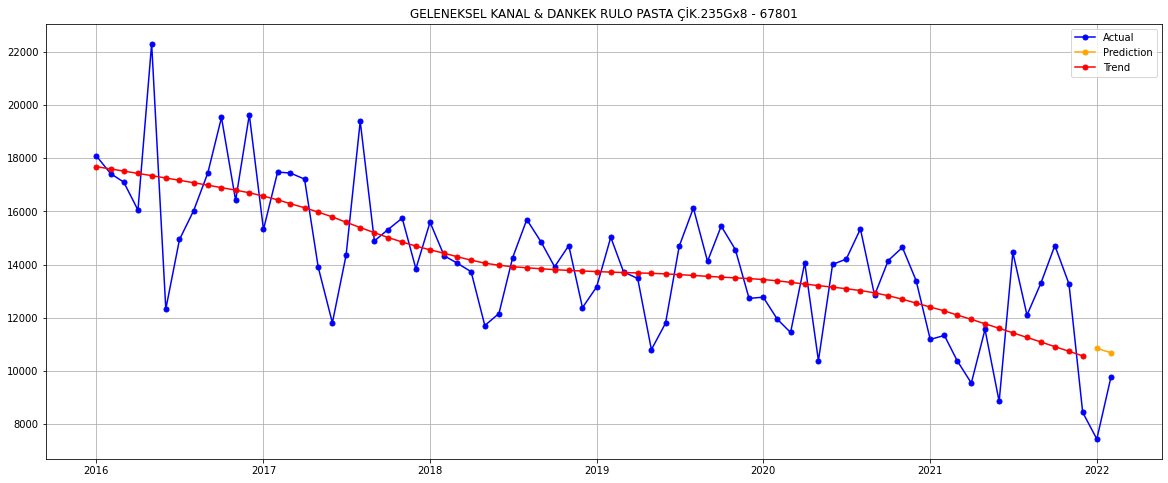



Geçmiş Şubat Ayları
-------------------
            date   koli  tahmin_koli aktivite_tipi indirim_yuzdesi
61210 2016-02-01  17423          NaN           Yok               0
61222 2017-02-01  17478          NaN           Yok               0
61234 2018-02-01  14328          NaN           Yok               0
61246 2019-02-01  15026          NaN           Yok         %5 - %6
61258 2020-02-01  11943          NaN           Yok               0
61270 2021-02-01  11335          NaN           Yok               0


Tahminlenen Aylar - Yöntem: hierarchical_forecast
-----------------
            date  koli  tahmin_koli aktivite_tipi indirim_yuzdesi
66635 2022-01-01  7438      10851.0           Yok         %0 - %1
66634 2022-02-01  9770      10682.0           Yok         %1 - %2




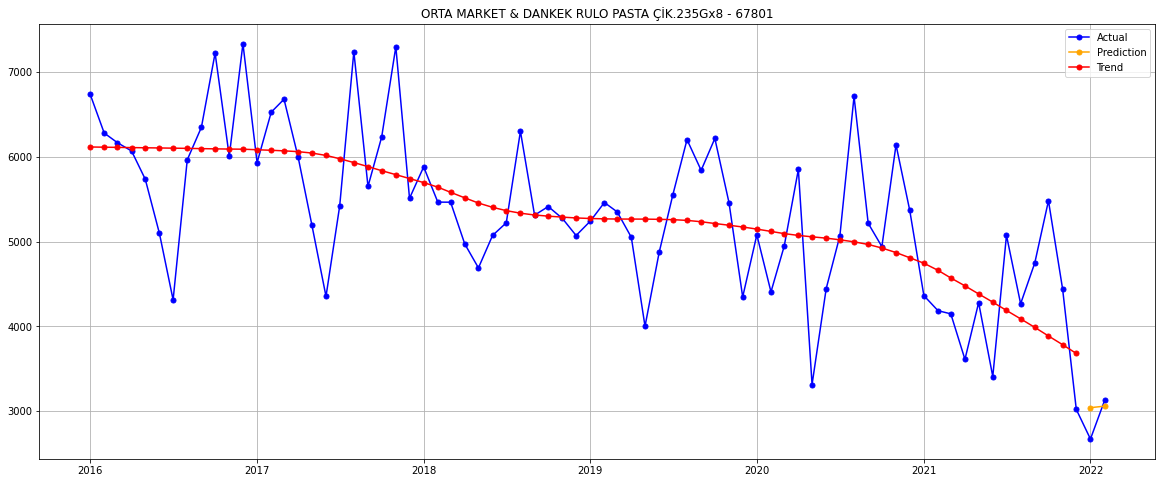



Geçmiş Şubat Ayları
-------------------
            date  koli  tahmin_koli aktivite_tipi indirim_yuzdesi
61282 2016-02-01  6281          NaN           Yok               0
61294 2017-02-01  6527          NaN           Yok               0
61306 2018-02-01  5466          NaN           Yok               0
61318 2019-02-01  5461          NaN           Yok         %5 - %6
61330 2020-02-01  4407          NaN           Yok               0
61342 2021-02-01  4185          NaN           Yok               0


Tahminlenen Aylar - Yöntem: autoforecast
-----------------
            date  koli  tahmin_koli aktivite_tipi indirim_yuzdesi
66637 2022-01-01  2671       3041.0           Yok         %0 - %1
66638 2022-02-01  3126       3059.0           Yok         %0 - %1




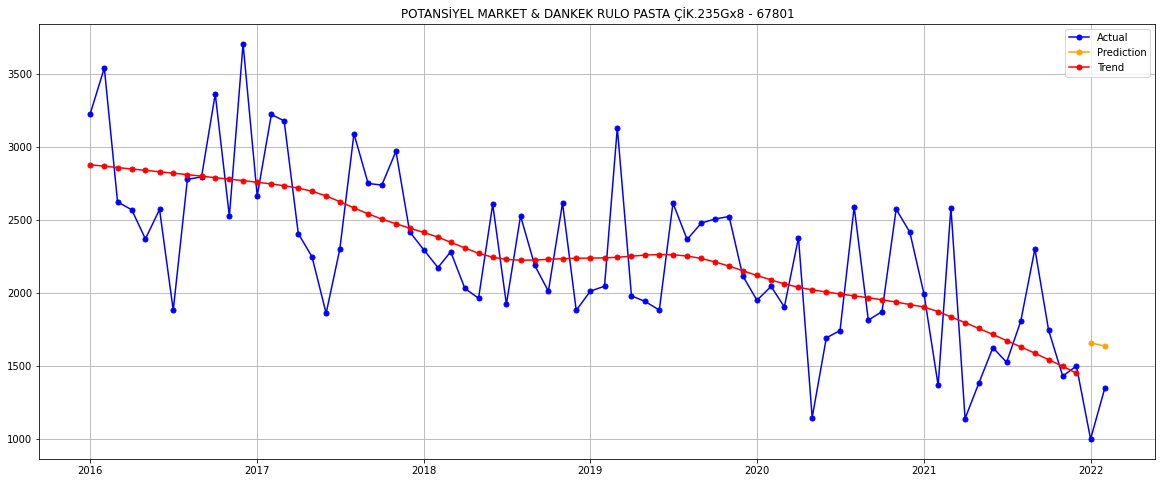



Geçmiş Şubat Ayları
-------------------
            date  koli  tahmin_koli aktivite_tipi indirim_yuzdesi
61354 2016-02-01  3539          NaN           Yok         %8 - %9
61366 2017-02-01  3221          NaN           Yok         %7 - %8
61378 2018-02-01  2174          NaN           Yok               0
61390 2019-02-01  2046          NaN           Yok         %2 - %3
11    2020-02-01  2045          NaN           Yok         %1 - %2
23    2021-02-01  1368          NaN           Yok               0


Tahminlenen Aylar - Yöntem: hierarchical_forecast
-----------------
            date  koli  tahmin_koli aktivite_tipi indirim_yuzdesi
66639 2022-01-01  1001       1659.0           Yok         %1 - %2
66640 2022-02-01  1347       1637.0           Yok         %2 - %3




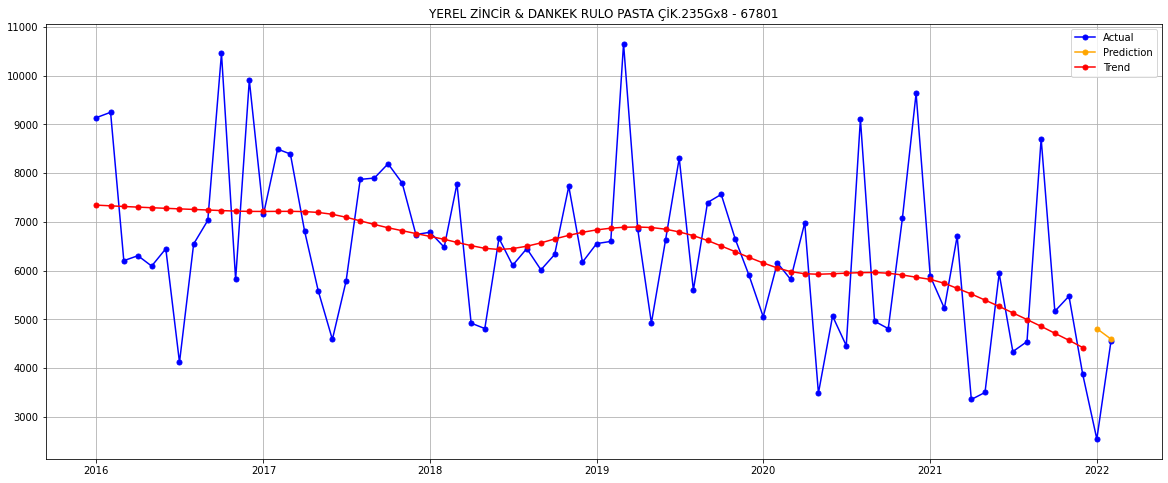



Geçmiş Şubat Ayları
-------------------
         date  koli  tahmin_koli aktivite_tipi indirim_yuzdesi
35 2016-02-01  9248          NaN           Yok       %10 - %15
47 2017-02-01  8493          NaN           Yok        %9 - %10
59 2018-02-01  6481          NaN           Yok               0
71 2019-02-01  6600          NaN           Yok         %3 - %4
83 2020-02-01  6160          NaN           Yok         %8 - %9
95 2021-02-01  5227          NaN           Yok               0


Tahminlenen Aylar - Yöntem: autoforecast
-----------------
            date  koli  tahmin_koli aktivite_tipi indirim_yuzdesi
66643 2022-01-01  2547       4812.0           Yok         %2 - %3
66644 2022-02-01  4553       4597.0           Yok         %2 - %3




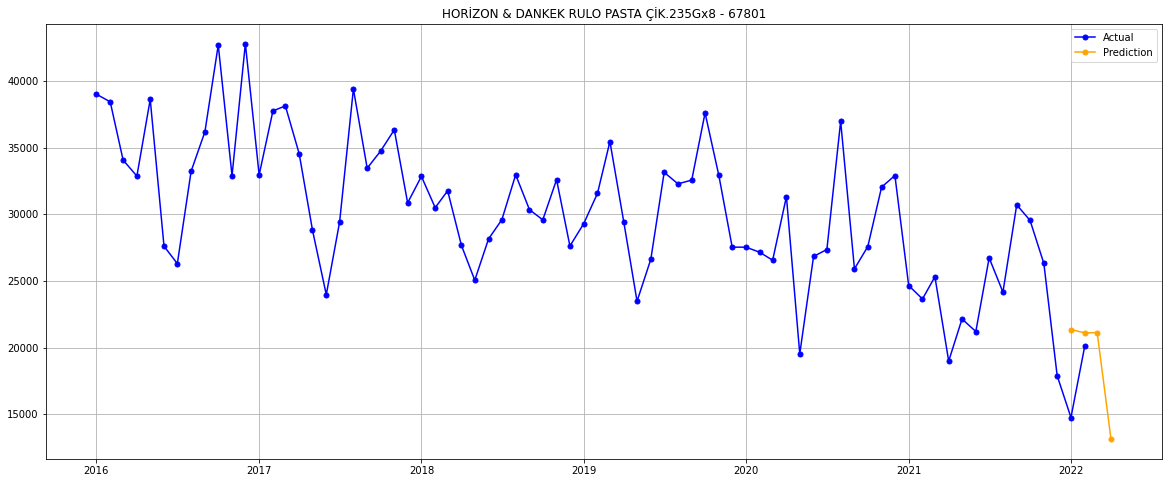

        date    Kanal  en_guncel_kod  tahmin_koli   koli
0 2022-01-01  HORİZON          67801        21352  14754
1 2022-02-01  HORİZON          67801        21101  20105
2 2022-03-01  HORİZON          67801        21123      0
3 2022-04-01  HORİZON          67801        13140      0


In [56]:
month_info = data_name_dict[t_2.month]
for grp_adi in kanal_grup_dict[kanal_adi_id]:
    df_draw = df_all2[(df_all2["grup_adi"] == grp_adi) & (df_all2["en_guncel_kod"] == sku_id)]
#    print(df_draw[["date", "koli", "tahmin_koli", "aktivite_tipi", "indirim_yuzdesi"]])
    df_draw["yil"] = df_draw["date"].dt.year
    df_draw["ay"] = df_draw["date"].dt.month
    years = [year for year in df_draw.yil.unique() if year != df_draw.date.max().year]
    df_draw_trend = df_all_v8_v2[(df_all_v8_v2["grup_adi"] == grp_adi) & (df_all_v8_v2["en_guncel_kod"] == sku_id)]
    df_draw_predict = results3[(results3["grup_adi"] == grp_adi) & (results3["en_guncel_kod"] == sku_id)]
    df_draw.drop_duplicates(inplace=True)
    df_draw_trend.drop_duplicates(inplace=True)
    df_draw.sort_values(by="date", inplace=True)
    df_draw_trend.sort_values(by="date", inplace=True)
    try:
        tahmin_edilme_yont = df_draw_predict[~(df_draw_predict["tahmin_edilme_yontemi"].isna())].tahmin_edilme_yontemi.unique()[0]
        urun_adi = df_draw[~(df_draw["urun_adi"].isna())].urun_adi.unique()[0]
        g_adi = df_draw["grup_adi"].unique()[0]
        sku_adi = df_draw["en_guncel_kod"].unique()[0]
        plt.figure(figsize=(20, 8))
        plt.title(f"{g_adi} & {urun_adi} - {sku_adi}") # plt.title(f"{g_adi} & {urun_adi} & {sku_adi}")
        plt.plot(df_draw['date'], df_draw["koli"], marker="o", markersize=5, color="b") #plt.plot(df_draw['date'], df_draw["koli"], marker="o", markersize=5)
        plt.plot(df_draw['date'], df_draw["tahmin_koli"], marker="o", markersize=5, color="orange")
        plt.plot(df_draw_trend['date'], df_draw_trend["trend"], marker="o", markersize=5, color="r")
        plt.legend(["Actual", "Prediction", "Trend"])
        plt.grid()
        plt.show()
        print("\n")
        print(f"Geçmiş {month_info} Ayları")
        print("-"*len("Geçmiş Şubat Ayları"))
        print(df_draw[(df_draw["yil"].isin(years)) & (df_draw["ay"] == t_2.month)][["date", "koli", "tahmin_koli", "aktivite_tipi", "indirim_yuzdesi"]])
        print("\n")
        print("Tahminlenen Aylar - Yöntem:", tahmin_edilme_yont)
        print("-"*len("Tahminlenen Aylar"))
        print(df_draw[df_draw["date"].isin(results3.date.unique())][["date", "koli", "tahmin_koli", "aktivite_tipi", "indirim_yuzdesi"]])
        print("\n")
    except IndexError as e:
        pass
df_draw = df_all2[(df_all2["Kanal"] == kanal_adi_id2) & (df_all2["en_guncel_kod"] == sku_id)]
df_draw_predict = results3[(results3["Kanal"] == kanal_adi_id2) & (results3["en_guncel_kod"] == sku_id)]
df_draw_kumulatif = df_draw.groupby(["date", "Kanal", "en_guncel_kod"]).sum().reset_index()
df_draw_pred_kumulatif = df_draw_predict.groupby(["date", "Kanal", "en_guncel_kod"]).sum().reset_index()
df_draw_pred_kumulatif = df_draw_pred_kumulatif[df_draw_pred_kumulatif["date"].isin(results3.date.unique())]
plt.figure(figsize=(20, 8))
plt.title(f"{kanal_adi_id2} & {urun_adi} - {sku_adi}") # plt.title(f"{g_adi} & {urun_adi} & {sku_adi}")
plt.plot(df_draw_kumulatif['date'], df_draw_kumulatif["koli"], marker="o", markersize=5, color="b") #plt.plot(df_draw['date'], df_draw["koli"], marker="o", markersize=5)
plt.plot(df_draw_pred_kumulatif['date'], df_draw_pred_kumulatif["tahmin_koli"], marker="o", markersize=5, color="orange")
plt.legend(["Actual", "Prediction", "Trend"])
plt.grid()
plt.show()

print(df_draw_pred_kumulatif)